# KNN, NON PE / PE.

## Analisis data menggunakan algoritma KNN (K-Nearest Neighbors) untuk mengklasifikasikan data preeklampsia berdasarkan beberapa faktor.  
1. Melatih model KNN untuk memprediksi apakah seseorang berisiko mengalami preeklampisa / tidak
2. Mengevaluasi model menggunakan berbagai metrik, seperti akurasi, laporan klasifikasi, matriks kebingungan dan ROC Curve (receiver operating characteristic) untuk setiap kelas
3. Menemukan nilai terbaik dari jumlah neighbors yang memberikan akurasi tertinggi melalui cross-validation dan grid search

In [109]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE  # Library untuk penyeimbangan kelas
from imblearn.over_sampling import RandomOverSampler


In [110]:
# Step 1: memuat dataset
file_path = r"C:\Users\HP\Documents\data mining\dataset\dataKasus-1.xlsx"
data = pd.read_excel(file_path)

In [111]:
# Step 2: eksplorasi awal (menampilkan informasi dasar dan beberapa baris pertama)
print("Dataset Info:")
print(data.info())
print("\nFirst few rows:")
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   NO                                561 non-null    int64 
 1   NAMA                              561 non-null    object
 2   USIA                              558 non-null    object
 3   PARITAS                           561 non-null    int64 
 4   JARAK KELAHIRAN                   554 non-null    object
 5   RIW HIPERTENSI                    561 non-null    object
 6   RIW PE                            561 non-null    object
 7   OBESITAS                          561 non-null    object
 8   RIW DM                            561 non-null    object
 9   RIW HIPERTENSI/PE DALAM KELUARGA  561 non-null    object
 10  SOSEK RENDAH                      561 non-null    object
 11  PE/Non PE                         561 non-null    object
 12  Unnamed:

In [112]:
# Step 3: hapus kolom yg tdk relevan (sesuaikan berdasarkan kolom datasetnya)
# contoh 'NO' dan 'NAMA' dihapus
data_cleaned = data.drop(columns=['NO', 'NAMA'], errors='ignore')  
# gunakan errors = 'ignore' untuk menghindari kesalahan jika ada kolom yg hilang 

In [113]:
# Step 4: menangani kolom non - numerik dgn pengkodean
# mengidentifikasi kolom non - numerik
non_numeric_cols = data_cleaned.select_dtypes(include=['object']).columns
# mengkodekan kolom non - numerik menjadi nilai numerik 
for col in non_numeric_cols:
    le = LabelEncoder()
    data_cleaned[col] = le.fit_transform(data_cleaned[col].astype(str))

In [114]:
# Step 5: tentukan fitur x dan target y 
# dengan asumsi PE / NON PE adalah kolom target 
X = data_cleaned.drop(columns=['PE/Non PE'], errors='ignore')
y = data_cleaned['PE/Non PE']

In [115]:
# Step 6: Menyeimbangkan data menggunakan SMOTE dengan pengaturan k_neighbors yang lebih kecil
# Coba mulai dengan k_neighbors=1 jika terdapat kelas dengan hanya 1 sampel
oversampler = RandomOverSampler(random_state=42)
X_res, y_res = oversampler.fit_resample(X, y)
# Step 7: Membagi data ke dalam set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)


In [116]:
# Step 8: Normalisasi/Penskalaan fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [117]:
# Step 9: Inisialisasi GridSearchCV untuk menemukan 'k' terbaik serta 'weights' dan 'metric'
param_grid = {
    'n_neighbors': np.arange(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
grid_search.fit(X_res, y_res)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [118]:
# Menampilkan 'k' terbaik dan parameter lainnya
best_params = grid_search.best_params_
best_k = best_params['n_neighbors']
print("\nBest Parameters found by GridSearchCV:", best_params)



Best Parameters found by GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [119]:
# Step 10: Melatih model KNN dengan parameter terbaik
knn_best = KNeighborsClassifier(n_neighbors=best_k, weights=best_params['weights'], metric=best_params['metric'])
knn_best.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [120]:
# Step 11: Memprediksi pada set pengujian dan mengevaluasi
y_pred = knn_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)


Accuracy: 0.9853479853479854

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       156
           1       1.00      0.96      0.98       156
           2       0.99      0.94      0.96       156
           3       1.00      1.00      1.00       156
           4       0.94      1.00      0.97       156
           5       0.99      1.00      0.99       156
           6       1.00      1.00      1.00       156

    accuracy                           0.99      1092
   macro avg       0.99      0.99      0.99      1092
weighted avg       0.99      0.99      0.99      1092


Confusion Matrix:
 [[156   0   0   0   0   0   0]
 [  2 149   2   0   1   2   0]
 [  0   0 147   0   9   0   0]
 [  0   0   0 156   0   0   0]
 [  0   0   0   0 156   0   0]
 [  0   0   0   0   0 156   0]
 [  0   0   0   0   0   0 156]]


In [121]:
# Step 12: Menghasilkan ROC Curve untuk setiap kelas
y_binarized = label_binarize(y_test, classes=np.unique(y_res))
n_classes = y_binarized.shape[1]

In [122]:
# Pengklasifikasi OneVsRest untuk prediksi probabilitas
knn_ovr = OneVsRestClassifier(knn_best)
y_prob = knn_ovr.fit(X_train, y_train).predict_proba(X_test)

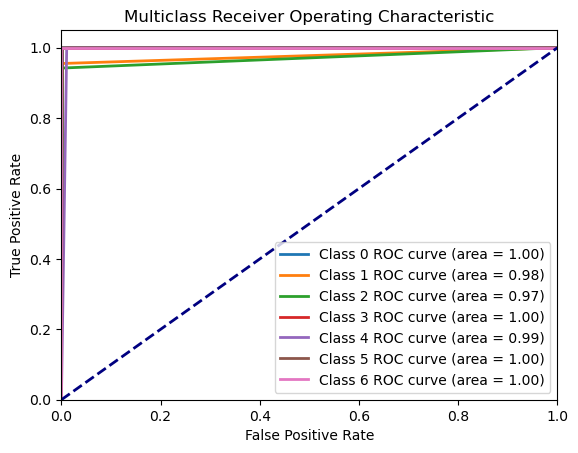

In [123]:
# Plot ROC Curve untuk setiap kelas
plt.figure()
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [124]:
# Step 13: Cross-validation dengan model terbaik
cv_scores = cross_val_score(knn_best, X_res, y_res, cv=5, scoring='accuracy')
print("\nAverage cross-validation score with best parameters:", cv_scores.mean())


Average cross-validation score with best parameters: 0.8598901098901098


code sblmnya :

In [125]:
# Step 7: inisialisasi pengklasifikasi KNN dan latih model 
knn = KNeighborsClassifier(n_neighbors=5)  
# n_neighbors dapat disetel  
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [126]:
# Step 8: memprediksi pada set pengujian dan mengevaluasi
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", report)


Accuracy: 0.9771062271062271

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       156
           1       1.00      0.90      0.95       156
           2       0.97      0.94      0.96       156
           3       0.99      1.00      1.00       156
           4       0.92      1.00      0.96       156
           5       0.97      1.00      0.98       156
           6       1.00      1.00      1.00       156

    accuracy                           0.98      1092
   macro avg       0.98      0.98      0.98      1092
weighted avg       0.98      0.98      0.98      1092



hasil run diatas : 
1. precision : memprediksi label tertentu dengan benar
2. recal : menemukan semua sampel dari label tertentu yang ada dalam dataset
3. f1-score : rata - rata harmonis dari precision dan recal, memberikan gambaran keseimbangan antara keduanya 
4. support : jumlah sampel sebenarnya dalam setiap kelas di set pengujian
5. kelas 1 : memiliki precision 0.92, recall 0.99, f1-score 0.95 yang menunjukkan bahwa model bekerja dengan baik dalam memprediksi kelas 1 (preeklampsia non-positif / negatif)
6. kelas 2,3,4,6 : metrik precision, recall, f1-score semuanya 0.00. ini terjadi karena model tidak membuat prediksi untuk kelas. 

In [127]:
# Step 9: Matrix kebingungan 
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


Confusion Matrix:
 [[156   0   0   0   0   0   0]
 [  2 140   4   1   4   5   0]
 [  0   0 147   0   9   0   0]
 [  0   0   0 156   0   0   0]
 [  0   0   0   0 156   0   0]
 [  0   0   0   0   0 156   0]
 [  0   0   0   0   0   0 156]]


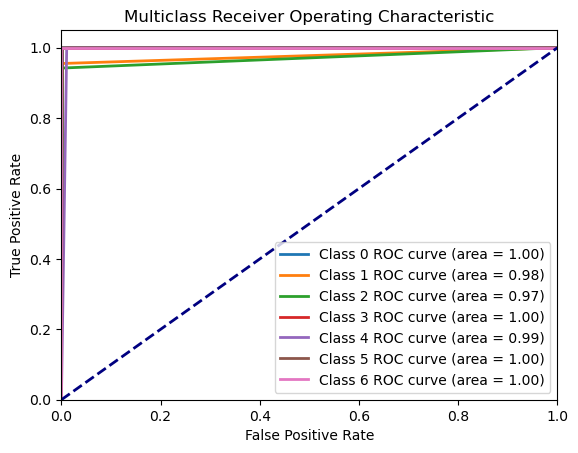

In [128]:
# membinerkan output untuk kurva ROC multiclass
y_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_binarized.shape[1]

# pengklasifikasi 1 vs sisa untuk mendapatkan estimasi probabilitas
knn_ovr = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=best_k))
y_prob = knn_ovr.fit(X_train, y_train).predict_proba(X_test)

# # Ensure class indices align within the bounds of y_prob columns
# present_classes = [i for i in range(min(n_classes, y_prob.shape[1])) if y_binarized[:, i].sum() > 0 and np.any(y_prob[:, i] > 0)]

# tentukan present dengan batasan yg lebih ketat untuk menghindari masalah di luar batas 
present_classes = [i for i in range(min(n_classes, y_prob.shape[1])) 
                   if i < y_prob.shape[1] and y_binarized[:, i].sum() > 0 and np.any(y_prob[:, i] > 0)]

# Plot kurva roc untuk setiap kelas yg valid
plt.figure()
for i in present_classes:
    try:
        fpr, tpr, _ = roc_curve(y_binarized[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')
    except ValueError:
        print(f"Skipping class {i} due to probability or sample issues.")

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [129]:
# Step 11: penyetelan hyperparameter dgn gricsearchcv untuk menemukan 'k' terbaik
param_grid = {'n_neighbors': np.arange(1, 21)}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
             scoring='accuracy')

In [130]:
# skor k dan validasi silang terbaik 
best_k = grid_search.best_params_['n_neighbors']
best_k_score = grid_search.best_score_
print("\nBest k found by GridSearchCV:", best_k)
print("Best cross-validation score with best k:", best_k_score)


Best k found by GridSearchCV: 9
Best cross-validation score with best k: 0.92692793931732


In [131]:
# Step 12: validasi silang dgn k terbaik
knn_best = KNeighborsClassifier(n_neighbors=best_k)
cv_scores = cross_val_score(knn_best, X, y, cv=5, scoring='accuracy')
print("\nAverage cross-validation score with best k:", cv_scores.mean())


Average cross-validation score with best k: 0.92692793931732


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
